<a href="https://colab.research.google.com/github/TimurRakhmat/ML/blob/main/sem2/CP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Курсовая работа Raisin Dataset

Группа М8О-109СВ-24

Рахматуллин Тимур Сергеевич

Данные

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, recall_score, accuracy_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, roc_auc_score, auc
from sklearn.metrics import roc_curve, average_precision_score, precision_recall_curve
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")


# Описание датасета
Датасет используется для классификации зерен изюма с использованием машинного зрения и искусственного интеллекта.


Этот набор данных содержит 900 образцов зерен изюма (по 450 от каждого из двух сортов: Кечимен и Бесни), а также 7 извлеченных морфологических признаков для каждого зерна. Эти характеристики были рассчитаны на основе изображений изюма, а набор данных предназначен для задач классификации, позволяющих различать два сорта изюма.



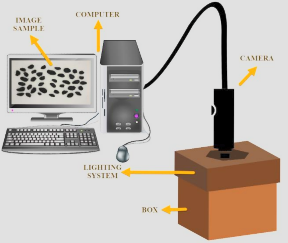
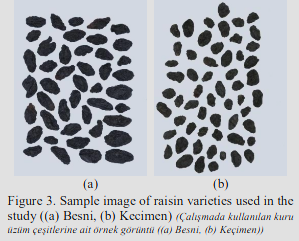

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/examples/Raisin_Dataset.xlsx", engine='openpyxl')

In [ ]:
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             900 non-null    int64  
 1   MajorAxisLength  900 non-null    float64
 2   MinorAxisLength  900 non-null    float64
 3   Eccentricity     900 non-null    float64
 4   ConvexArea       900 non-null    int64  
 5   Extent           900 non-null    float64
 6   Perimeter        900 non-null    float64
 7   Class            900 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 56.4+ KB


In [ ]:
def grab_column_names(df, cardinality_threshold=20):
    numeric_columns = df.select_dtypes(include=["number"]).columns.tolist()

    categorical_columns = df.select_dtypes(include=["object", "category"]).columns.tolist()

    cardinal_columns = [col for col in categorical_columns if df[col].nunique() > cardinality_threshold]

    return numeric_columns, categorical_columns, cardinal_columns

numeric_columns, categorical_columns, cardinal_columns = grab_column_names(df)

In [ ]:
numeric_columns

['Area',
 'MajorAxisLength',
 'MinorAxisLength',
 'Eccentricity',
 'ConvexArea',
 'Extent',
 'Perimeter']

#ОБОЗНАЧЕНИЯ
*   Площадь: количество пикселей в пределах границы изюма.
*  MajorAxisLength: длина самой длинной оси, которую можно нарисовать на изюме.
* MinorAxisLength: длина самой короткой оси,
* Eccentricity: Мера того, насколько вытянут изюм по сравнению с идеальным кругом.
* ConvexArea: количество пикселей самой маленькой выпуклой оболочки, окружающей изюм.
* Extent: отношение области, образованной изюмом, к общему количеству пикселей в ограничивающем прямоугольнике.
* Perimeter: Расстояние вокруг границы изюма



In [ ]:
categorical_columns

['Class']

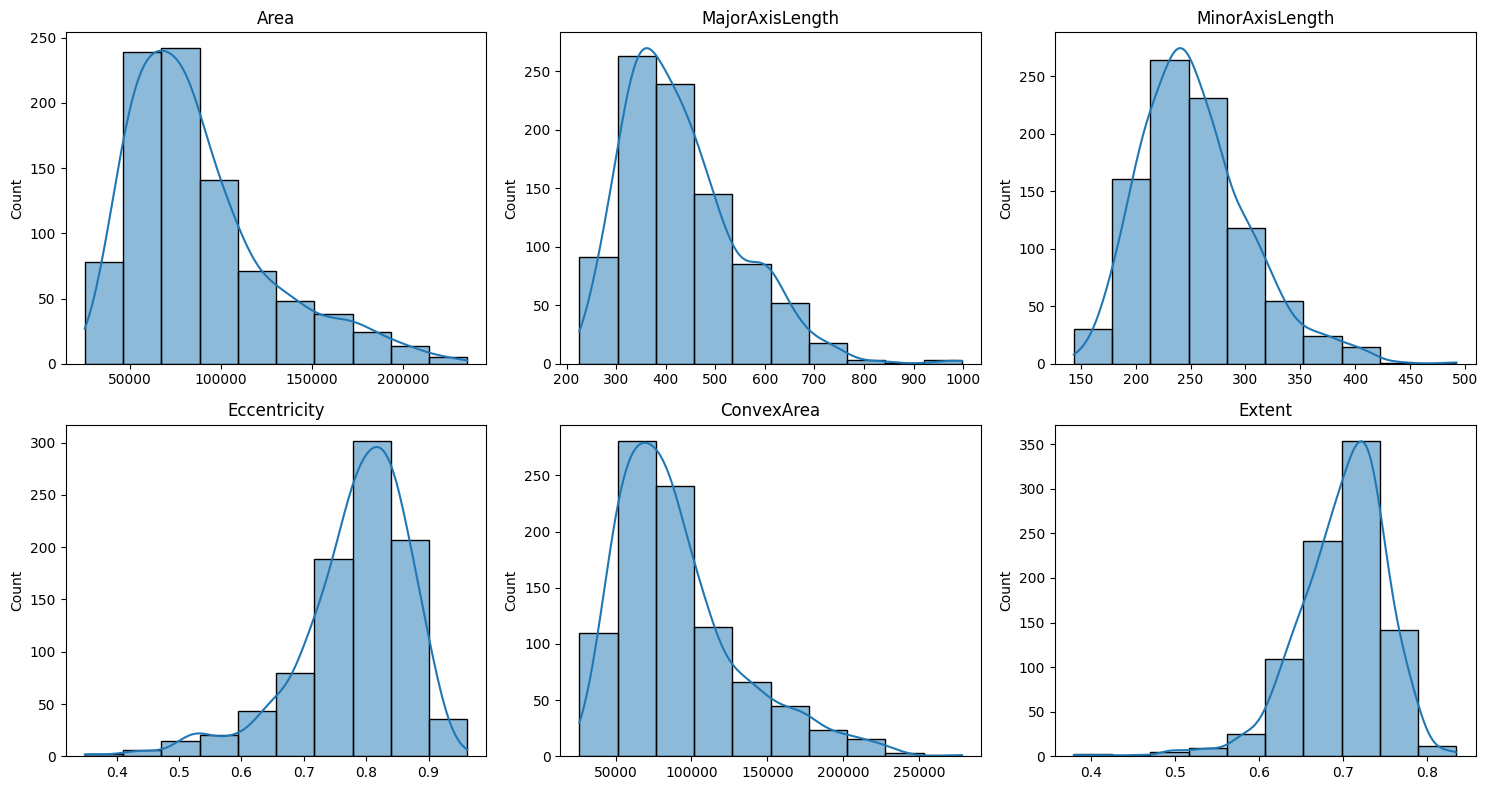

In [ ]:
def plot_histograms(df, columns, rows=2, cols=3):
    """
    Plot histograms for specified columns in a dataframe.

    Args:
    df (pandas.DataFrame): The dataframe containing the data.
    columns (list): List of column names to plot.
    rows (int): Number of rows in the plot grid. Default is 2.
    cols (int): Number of columns in the plot grid. Default is 3.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axes = axes.flatten()  # Flatten axes array for easy indexing

    for i, col in enumerate(columns):
        if i < len(axes):  # Check if we have enough subplots
            sns.histplot(df[col], kde=True, ax=axes[i], bins=10)
            axes[i].set_title(col)
            axes[i].set_xlabel('')  # Remove x-label as it's redundant with title

    # Remove unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_histograms(df, numeric_columns, rows=2, cols=3)

In [ ]:
numeric_df = df[numeric_columns]
numeric_df.corr()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
Area,1.000000,0.932774,0.906650,0.336107,0.995920,-0.013499,0.961352
MajorAxisLength,0.932774,1.000000,0.728030,0.583608,0.945031,-0.203866,0.977978
MinorAxisLength,0.906650,0.728030,1.000000,-0.027683,0.895651,0.145322,0.827417
Eccentricity,0.336107,0.583608,-0.027683,1.000000,0.348210,-0.361061,0.447845
ConvexArea,0.995920,0.945031,0.895651,0.348210,1.000000,-0.054802,0.976612
Extent,-0.013499,-0.203866,0.145322,-0.361061,-0.054802,1.000000,-0.173449
Perimeter,0.961352,0.977978,0.827417,0.447845,0.976612,-0.173449,1.000000


<Axes: >

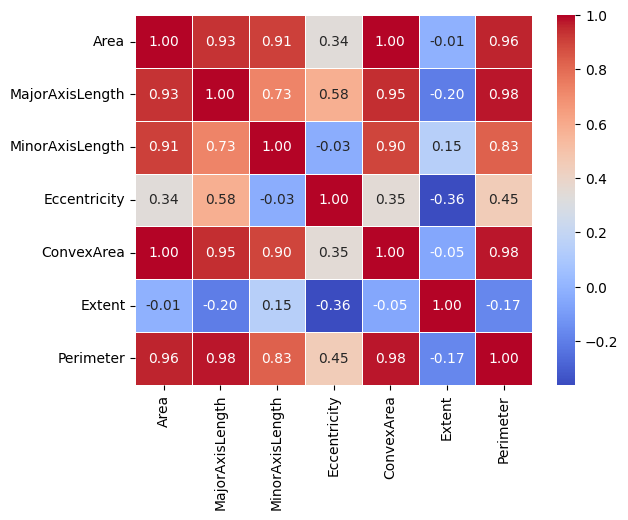

In [ ]:
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

Обучение

In [61]:
X = df.drop("Class", axis=1)
y = df["Class"]


In [62]:
df = df.replace(to_replace='Besni', value=0)
df = df.replace(to_replace='Kecimen', value=1)
y = df["Class"]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [52]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Лучшая комбинация параметров:", grid_search.best_params_)
print("Accuracy на тестовой выборке: {:.4f}".format(accuracy))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Лучшая комбинация параметров: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Accuracy на тестовой выборке: 0.8556


# SHAP


In [53]:
from sklearn.metrics import accuracy_score
import shap

In [56]:
explainer = shap.Explainer(best_model, X_train, feature_names=numeric_columns)
shap_values = explainer(X_test)

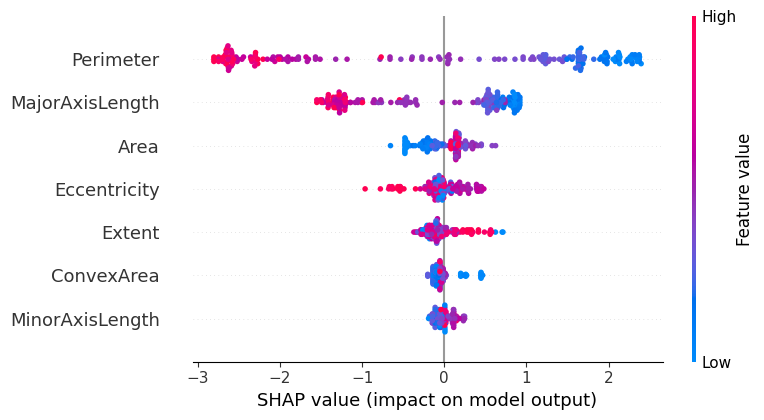

In [57]:
shap.summary_plot(shap_values, X_test)

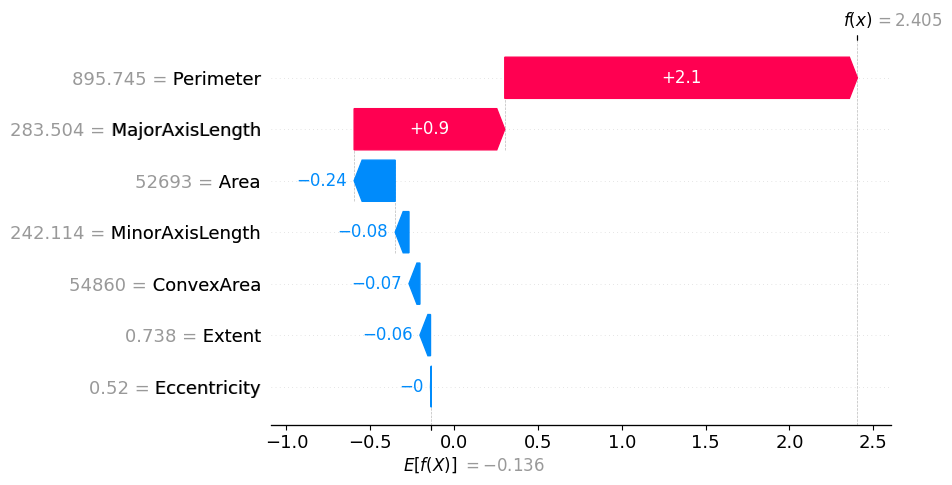

In [58]:
shap.plots.waterfall(shap_values[2])

SHAP-анализ показал, что наиболее важными признаками для предсказания стоимости поездки являются:

Самые важные признаки:
* Периметр
* Максимальная длина
* площадь

## **PFI (Доп. метод)**
Permutation Feature Importance (важность признаков по перестановке) - измеряет, как ухудшается качество модели, если случайным образом перемешать значения одного признака

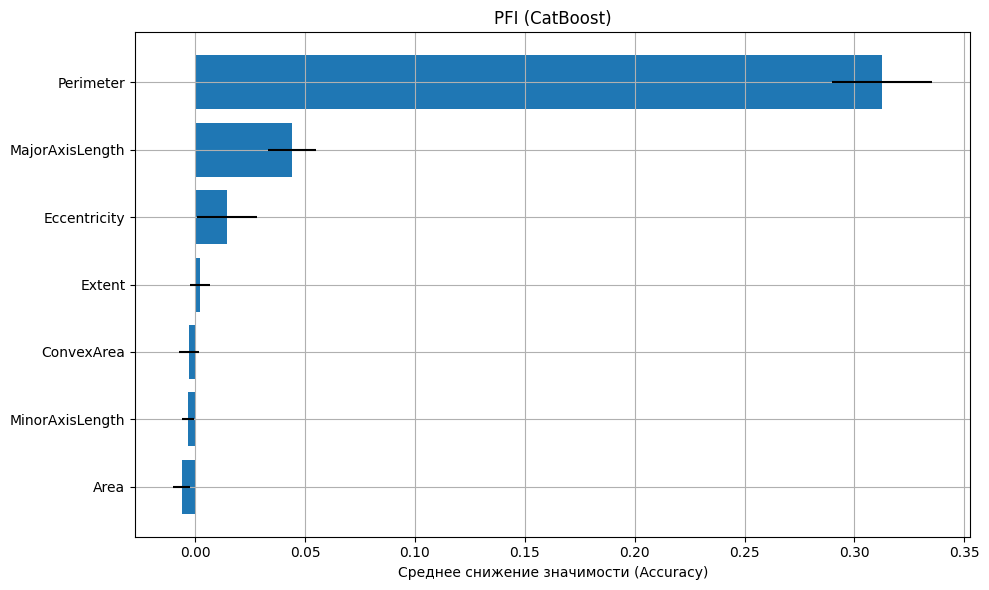

In [60]:
from sklearn.inspection import permutation_importance
permutation_result = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy'
)

importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': permutation_result.importances_mean,
    'importance_std': permutation_result.importances_std
}).sort_values(by='importance_mean', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance_mean'], xerr=importance_df['importance_std'])
plt.gca().invert_yaxis()
plt.xlabel("Среднее снижение значимости (Accuracy)")
plt.title("PFI (CatBoost)")
plt.grid(True)
plt.tight_layout()
plt.show()

Порядок признаков совпадает с SHAP. Permutation Importance измеряет, насколько ухудшается качество модели при случайном перемешивании значений признака. Высокая важность периметра и Максимальная длина указывает на их критическую роль в предсказании.


**Интерпретация собственной записи**

In [64]:
my_rasin = pd.DataFrame([{
    'Area' : 70000,
 'MajorAxisLength' : 500,
 'MinorAxisLength': 100,
 'Eccentricity' : 0.719738,
 'ConvexArea' : 80000,
 'Extent' : 0.8555,
 'Perimeter' : 1000
}])

type:  Kecimen


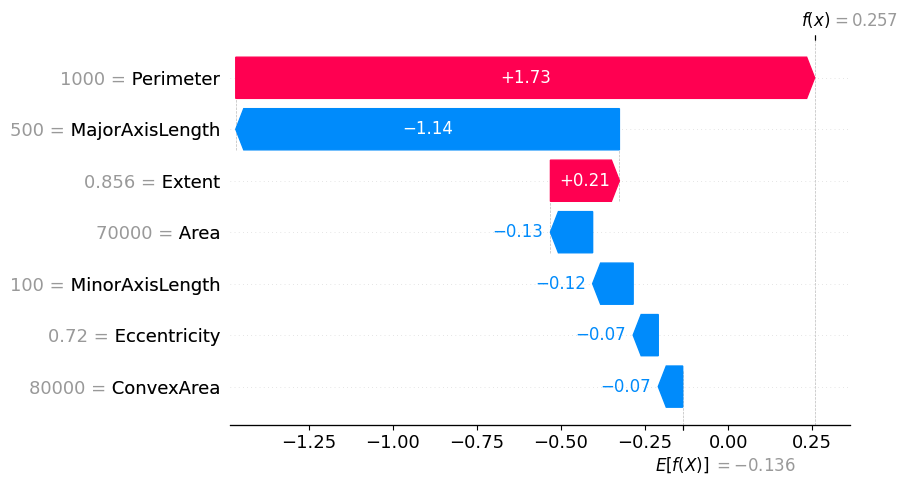

In [67]:
type_of_r = ["Besni", "Kecimen"]
predicted_fare = best_model.predict(my_rasin)[0]
print("type: ", type_of_r[predicted_fare])

shap_values_custom = explainer(my_rasin)
shap.plots.waterfall(shap_values_custom[0])

Набольший вклад в определение внес большой периметр, слишком же большой размер максимальной оси наоборот занизил вероятность принадлежности к классу Kecimen

# ВЫВОД
При глобальной интерпретации SHAP и PFI пришли к согласованному выводу, подтвердив значимость одних и тех же признаков в принятии решения моделью.